In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'fr'
target_lang = 'fr'
model_size = '7b'
prefix = "./data/langs/"
type = 'logit'

In [4]:
# Parameters
model_size = "7b"
target_lang = "fr"
input_lang = "en"
type = "tuned"


In [5]:
df_en_input = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_target = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()
llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
    
latent="en"
if type == 'logit':
    llama_lens = LogitLens.from_model(llama).to("cuda")
    out_dir = f'./visuals/logit'
if type == 'tuned':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-{model_size}-hf").to("cuda")
    out_dir = f'./visuals/tuned'
if type == 'tuned-chinese':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese'
    latent = 'zh'
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

params.pt AlignmentResearch/tuned-lens space main lens/meta-llama/Llama-2-7b-hf None


params.pt:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

(…)ens/meta-llama/Llama-2-7b-hf/config.json:   0%|          | 0.00/258 [00:00<?, ?B/s]

In [6]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=4096, out_features=32000, bias=False)
)
U torch.Size([32000, 4096]) weights torch.Size([1, 4096])


0.058621685951948166


In [7]:
count = 0
for idx, word in enumerate(df_en_target['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_target)} are single tokens')

if input_lang == target_lang:
    df_en_target_input = df_en_target.copy()
    df_en_target_input.rename(columns={'word_original': 'en', 
                                f'word_translation': target_lang if target_lang != 'en' else 'en_tgt'}, 
                                inplace=True)
else:
    df_en_target_input = df_en_target.merge(df_en_input, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    df_en_target_input.rename(columns={'word_original': 'en', 
                                f'word_translation_{target_lang}': target_lang if target_lang != 'en' else 'en_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != 'en' else 'en_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != 'en':
    for i, row in df_en_target_input.iterrows():
        if row['en'].lower() in row[target_lang].lower():
            df_en_target_input.drop(i, inplace=True)

print(f'final length of df_en_{target_lang}_{input_lang}: {len(df_en_target_input)}')

for fr 68 of 118 are single tokens
final length of df_en_fr_en: 100


In [8]:
df_en_target_input

,lang_fr,en,fr,blank_prompt_original_fr,blank_prompt_translation_fr,blank_prompt_translation_masked_fr,error_fr,lang_en,en_in,blank_prompt_original_en,blank_prompt_translation_en,blank_prompt_translation_masked_en,error_en
0,fr,cloud,nuage,"A ""cloud"" is a visible mass of condensed water...","Un ""nuage"" est une masse visible de vapeur d'e...","Un ""___"" est une masse visible de vapeur d'eau...",no error,en,cloud,"A ""cloud"" is a visible mass of condensed water...","A ""cloud"" is a visible mass of condensed water...","A ""___"" is a visible mass of condensed water v...",no error
1,fr,bag,sac,"A ""bag"" is used to carry items. Answer: ""bag"".","Un ""sac"" est utilisé pour transporter des obje...","Un ""___"" est utilisé pour transporter des obje...",no error,en,bag,"A ""bag"" is used to carry items. Answer: ""bag"".","A ""bag"" is used to carry items. Answer: ""bag"".","A ""___"" is used to carry items. Answer: ""bag"".",no error
2,fr,mouth,bouche,"A ""mouth"" is used to eat food and speak. Answe...","La ""bouche"" sert à manger et à parler. Réponse...","La ""___"" sert à manger et à parler. Réponse : ...",no error,en,mouth,"A ""mouth"" is used to eat food and speak. Answe...","A ""mouth"" is used to eat food and speak. Answe...","A ""___"" is used to eat food and speak. Answer:...",no error
3,fr,soil,sol,"""A ""soil"" is used for planting trees and crops...","""Un ""sol"" est utilisé pour planter des arbres ...","""Un ""___"" est utilisé pour planter des arbres ...",no error,en,soil,"""A ""soil"" is used for planting trees and crops...","""A ""soil"" is used for planting trees and crops...","""A ""___"" is used for planting trees and crops....",no error
4,fr,mountain,montagne,"A ""mountain"" is a large natural elevation of t...","Une ""montagne"" est une grande élévation nature...","Une ""___"" est une grande élévation naturelle d...",no error,en,mountain,"A ""mountain"" is a large natural elevation of t...","A ""mountain"" is a large natural elevation of t...","A ""___"" is a large natural elevation of the ea...",no error
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,fr,rise,hausse,"""A ""rise"" is used to describe an increase or u...","""Une ""hausse"" est utilisée pour décrire une au...","""Une ""___"" est utilisée pour décrire une augme...",no error,en,rise,"""A ""rise"" is used to describe an increase or u...","""A ""rise"" is used to describe an increase or u...","""A ""___"" is used to describe an increase or up...",no error
114,fr,left,gauche,"'A ""left"" is a direction opposite to right. An...","Une ""gauche"" est une direction opposée à la dr...","Une ""___"" est une direction opposée à la droit...",no error,en,left,"'A ""left"" is a direction opposite to right. An...","'A ""left"" is a direction opposite to right. An...","'A ""___"" is a direction opposite to right. Ans...",no error
115,fr,sound,son,"A ""sound"" is something we hear. Answer: ""sound"".","Un ""son"" est quelque chose que l'on entend. Ré...","Un ""___"" est quelque chose que l'on entend. Ré...",no error,en,sound,"A ""sound"" is something we hear. Answer: ""sound"".","A ""sound"" is something we hear. Answer: ""sound"".","A ""___"" is something we hear. Answer: ""sound"".",no error
116,fr,power,pouvoir,"""A ""power"" is used to control or influence peo...","""Un ""pouvoir"" est utilisé pour contrôler ou in...","""Un ""___"" est utilisé pour contrôler ou influe...",no error,en,power,"""A ""power"" is used to control or influence peo...","""A ""power"" is used to control or influence peo...","""A ""___"" is used to control or influence peopl...",no error


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent=latent):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, latent)
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != 'en' and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
dataset = []
for ind in tqdm(range(len(df_en_target_input))):
    d = next(sample(df_en_target_input, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                                       | 0/100 [00:00<?, ?it/s]

  1%|██                                                                                                                                                                                                             | 1/100 [00:00<00:21,  4.53it/s]

  2%|████▏                                                                                                                                                                                                          | 2/100 [00:00<00:17,  5.61it/s]

  3%|██████▏                                                                                                                                                                                                        | 3/100 [00:00<00:19,  5.09it/s]

  4%|████████▎                                                                                                                                                                                                      | 4/100 [00:00<00:17,  5.44it/s]

  5%|██████████▎                                                                                                                                                                                                    | 5/100 [00:01<00:22,  4.25it/s]

  6%|████████████▍                                                                                                                                                                                                  | 6/100 [00:01<00:20,  4.67it/s]

  7%|██████████████▍                                                                                                                                                                                                | 7/100 [00:01<00:19,  4.67it/s]

  8%|████████████████▌                                                                                                                                                                                              | 8/100 [00:01<00:18,  4.91it/s]

  9%|██████████████████▋                                                                                                                                                                                            | 9/100 [00:01<00:18,  4.90it/s]

 10%|████████████████████▌                                                                                                                                                                                         | 10/100 [00:02<00:20,  4.45it/s]

 11%|██████████████████████▋                                                                                                                                                                                       | 11/100 [00:02<00:18,  4.72it/s]

 12%|████████████████████████▋                                                                                                                                                                                     | 12/100 [00:02<00:17,  4.98it/s]

 13%|██████████████████████████▊                                                                                                                                                                                   | 13/100 [00:02<00:18,  4.72it/s]

 14%|████████████████████████████▊                                                                                                                                                                                 | 14/100 [00:02<00:17,  4.86it/s]

 15%|██████████████████████████████▉                                                                                                                                                                               | 15/100 [00:03<00:18,  4.57it/s]

 16%|████████████████████████████████▉                                                                                                                                                                             | 16/100 [00:03<00:17,  4.76it/s]

 17%|███████████████████████████████████                                                                                                                                                                           | 17/100 [00:03<00:16,  4.89it/s]

 18%|█████████████████████████████████████                                                                                                                                                                         | 18/100 [00:03<00:15,  5.33it/s]

 19%|███████████████████████████████████████▏                                                                                                                                                                      | 19/100 [00:03<00:15,  5.33it/s]

 20%|█████████████████████████████████████████▏                                                                                                                                                                    | 20/100 [00:04<00:15,  5.28it/s]

 21%|███████████████████████████████████████████▎                                                                                                                                                                  | 21/100 [00:04<00:15,  5.16it/s]

 22%|█████████████████████████████████████████████▎                                                                                                                                                                | 22/100 [00:04<00:14,  5.57it/s]

 23%|███████████████████████████████████████████████▍                                                                                                                                                              | 23/100 [00:04<00:13,  5.63it/s]

 24%|█████████████████████████████████████████████████▍                                                                                                                                                            | 24/100 [00:04<00:15,  4.97it/s]

 25%|███████████████████████████████████████████████████▌                                                                                                                                                          | 25/100 [00:05<00:14,  5.19it/s]

 26%|█████████████████████████████████████████████████████▌                                                                                                                                                        | 26/100 [00:05<00:13,  5.29it/s]

 27%|███████████████████████████████████████████████████████▌                                                                                                                                                      | 27/100 [00:05<00:14,  5.12it/s]

 28%|█████████████████████████████████████████████████████████▋                                                                                                                                                    | 28/100 [00:05<00:14,  5.14it/s]

 29%|███████████████████████████████████████████████████████████▋                                                                                                                                                  | 29/100 [00:05<00:14,  4.92it/s]

 30%|█████████████████████████████████████████████████████████████▊                                                                                                                                                | 30/100 [00:05<00:12,  5.41it/s]

 31%|███████████████████████████████████████████████████████████████▊                                                                                                                                              | 31/100 [00:06<00:13,  5.28it/s]

 32%|█████████████████████████████████████████████████████████████████▉                                                                                                                                            | 32/100 [00:06<00:11,  5.72it/s]

 33%|███████████████████████████████████████████████████████████████████▉                                                                                                                                          | 33/100 [00:06<00:12,  5.32it/s]

 34%|██████████████████████████████████████████████████████████████████████                                                                                                                                        | 34/100 [00:06<00:12,  5.40it/s]

 35%|████████████████████████████████████████████████████████████████████████                                                                                                                                      | 35/100 [00:06<00:13,  4.94it/s]

 36%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 36/100 [00:07<00:11,  5.55it/s]

 37%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 37/100 [00:07<00:10,  5.74it/s]

 38%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 38/100 [00:07<00:11,  5.35it/s]

 39%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 39/100 [00:07<00:11,  5.13it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 40/100 [00:07<00:11,  5.21it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 41/100 [00:08<00:11,  5.22it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 42/100 [00:08<00:11,  5.22it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 43/100 [00:08<00:10,  5.40it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 44/100 [00:08<00:09,  5.76it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 45/100 [00:08<00:09,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 46/100 [00:08<00:10,  5.24it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 47/100 [00:09<00:10,  5.07it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 48/100 [00:09<00:08,  5.87it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 49/100 [00:09<00:09,  5.39it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 50/100 [00:09<00:09,  5.13it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 51/100 [00:09<00:09,  5.24it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 52/100 [00:10<00:09,  5.24it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 53/100 [00:10<00:09,  4.89it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 54/100 [00:10<00:10,  4.53it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 55/100 [00:10<00:09,  4.63it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 56/100 [00:11<00:09,  4.57it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 57/100 [00:11<00:09,  4.33it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 58/100 [00:11<00:09,  4.25it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 59/100 [00:11<00:09,  4.19it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 60/100 [00:11<00:09,  4.35it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 61/100 [00:12<00:08,  4.58it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 62/100 [00:12<00:08,  4.57it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 63/100 [00:12<00:07,  4.71it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 64/100 [00:12<00:08,  4.34it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 65/100 [00:13<00:07,  4.43it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 66/100 [00:13<00:07,  4.40it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 67/100 [00:13<00:08,  4.01it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 68/100 [00:13<00:07,  4.15it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 69/100 [00:14<00:08,  3.62it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 70/100 [00:14<00:07,  3.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 71/100 [00:14<00:07,  4.02it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 72/100 [00:14<00:06,  4.04it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 73/100 [00:15<00:07,  3.75it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 74/100 [00:15<00:06,  3.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 75/100 [00:15<00:06,  3.97it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 76/100 [00:16<00:06,  3.58it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 77/100 [00:16<00:05,  4.02it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 78/100 [00:16<00:05,  4.02it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 79/100 [00:16<00:05,  4.16it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 80/100 [00:16<00:04,  4.24it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 81/100 [00:17<00:04,  4.24it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 82/100 [00:17<00:04,  4.43it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 83/100 [00:17<00:04,  4.23it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 84/100 [00:17<00:04,  3.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 85/100 [00:18<00:03,  3.97it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 86/100 [00:18<00:03,  4.21it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 87/100 [00:18<00:02,  4.45it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 88/100 [00:18<00:02,  4.83it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 89/100 [00:18<00:02,  4.57it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 90/100 [00:19<00:02,  4.26it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 91/100 [00:19<00:02,  4.31it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 92/100 [00:19<00:01,  4.58it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 93/100 [00:19<00:01,  4.26it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 94/100 [00:20<00:01,  4.20it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 95/100 [00:20<00:01,  4.47it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 96/100 [00:20<00:00,  4.60it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 97/100 [00:20<00:00,  4.65it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 98/100 [00:20<00:00,  4.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 99/100 [00:21<00:00,  4.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.68it/s]

In [12]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [13]:
df

,prompt,out_token_id,out_token_str,latent_token_id,latent_token_str,in_token_str
0,"English: ""example"" - Français: ""exemple""\nEngl...","[4948, 302, 29876, 3433]",nuage,"[29883, 15126, 23642, 1067, 9274, 9570, 695, 2...",cloud,cloud
1,"English: ""city"" - Français: ""ville""\nEnglish: ...","[269, 29879, 872, 4977, 7067]",sac,"[289, 2291, 19548, 29890, 9922, 23156]",bag,bag
2,"English: ""dance"" - Français: ""danse""\nEnglish:...","[289, 29890, 1045, 16380, 833]",bouche,"[29442, 286, 2730, 29885, 4346, 13394, 21026]",mouth,mouth
3,"English: ""light"" - Français: ""lumière""\nEnglis...","[29883, 274]",cœur,"[29882, 23057, 5192, 8293, 354, 298, 540]",heart,heart
4,"English: ""sound"" - Français: ""son""\nEnglish: ""...","[611, 3396, 29885, 286, 1667, 655, 24402, 5530]",main,"[447, 29882, 5403, 2350, 5905, 1361, 298, 3179]",hand,hand
5,"English: ""ground"" - Français: ""sol""\nEnglish: ...","[29926, 20551, 432, 8121, 2212, 8694, 2958]",jour,"[2462, 1388, 270, 1146, 3250, 29881]",day,day
6,"English: ""office"" - Français: ""bureau""\nEnglis...","[904, 1893, 2852, 29948]",étoile,"[269, 29879, 380, 5810, 9523, 5173, 8508, 303]",star,star
7,"English: ""door"" - Français: ""porte""\nEnglish: ...","[620, 29878, 276, 364, 337, 690, 18475, 1253]",ressort,"[269, 29879, 15099, 1028, 7689, 6709, 4278, 805]",spring,spring
8,"English: ""virtue"" - Français: ""vertu""\nEnglish...","[8092, 25081, 301, 29880, 6092]",lune,"[18786, 29885, 286, 2730, 4346]",moon,moon
9,"English: ""spring"" - Français: ""ressort""\nEngli...","[289, 23734, 29890, 1045, 833]",bois,"[6115, 8112, 29893, 281, 827, 8879]",wood,wood


In [14]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    tensors=[]
    for i in range(32):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hidden_states).squeeze(1).detach().cpu()
    return tensors,hidden_states
        

In [15]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:00,  1.10it/s]

2it [00:01,  1.87it/s]

3it [00:01,  2.52it/s]

4it [00:01,  3.24it/s]

5it [00:01,  3.72it/s]

6it [00:01,  4.25it/s]

7it [00:02,  4.46it/s]

8it [00:02,  4.65it/s]

9it [00:02,  4.73it/s]

10it [00:02,  4.85it/s]

11it [00:02,  4.97it/s]

12it [00:03,  5.07it/s]

13it [00:03,  5.14it/s]

14it [00:03,  5.24it/s]

15it [00:03,  5.41it/s]

16it [00:03,  5.24it/s]

17it [00:04,  5.30it/s]

18it [00:04,  5.42it/s]

19it [00:04,  5.19it/s]

20it [00:04,  5.09it/s]

21it [00:04,  5.19it/s]

22it [00:05,  5.31it/s]

23it [00:05,  5.26it/s]

24it [00:05,  5.31it/s]

25it [00:05,  5.25it/s]

26it [00:05,  5.19it/s]

27it [00:05,  5.31it/s]

28it [00:06,  5.36it/s]

29it [00:06,  5.48it/s]

30it [00:06,  5.71it/s]

31it [00:06,  5.83it/s]

32it [00:06,  5.53it/s]

33it [00:07,  4.85it/s]

34it [00:07,  4.77it/s]

35it [00:07,  4.85it/s]

36it [00:07,  4.76it/s]

37it [00:07,  4.75it/s]

38it [00:08,  4.72it/s]

39it [00:08,  4.45it/s]

40it [00:08,  4.24it/s]

41it [00:08,  4.61it/s]

42it [00:09,  4.75it/s]

43it [00:09,  4.89it/s]

44it [00:09,  4.68it/s]

45it [00:09,  4.52it/s]

46it [00:09,  4.51it/s]

47it [00:10,  4.53it/s]

48it [00:10,  4.57it/s]

49it [00:10,  4.70it/s]

50it [00:10,  4.64it/s]

51it [00:11,  4.62it/s]

52it [00:11,  4.79it/s]

53it [00:11,  4.76it/s]

54it [00:11,  4.83it/s]

55it [00:11,  4.79it/s]

56it [00:12,  4.73it/s]

57it [00:12,  4.79it/s]

57it [00:12,  4.65it/s]

/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


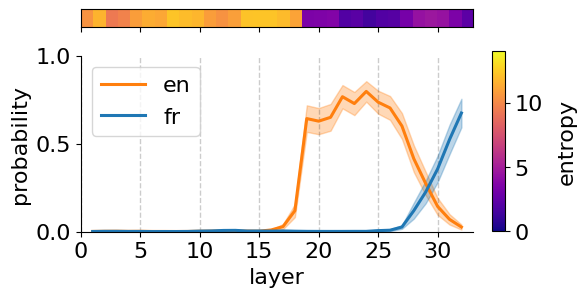

In [16]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.jpg', dpi=300, bbox_inches='tight')

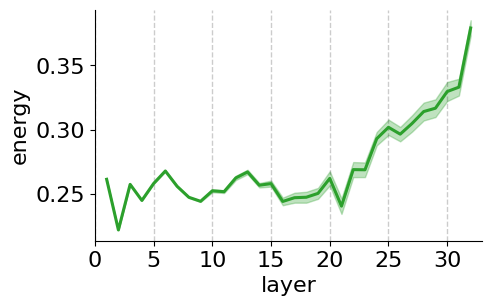

In [17]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.jpg', dpi=300, bbox_inches='tight')